### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import importlib
import re

import matplotlib.pyplot as plt

import findatree.io as io
import findatree.descriptions as descriptions

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

# Dictionaries: species_name to ba and vice versa
species_id_to_name = descriptions.species_id_to_name()
species_name_to_id = descriptions.species_name_to_id()

### Definitions

In [2]:
# Directory: Processed tnr%.hdf5s
dir_hdf5 = r"C:\Data\lwf\processed\2020\hdf5"

# Directory: Plots
dir_plots = r"C:\Data\lwf\analysis\2208229_geometries\plots"

### Load crowns' features of all hdf5s
* As pandas.DataFrame

In [3]:
importlib.reload(io)

df, params_df = io.allhdf5s_crowns_features_to_dataframe(dir_hdf5, crowns_type='crowns_human')

# Replace inf values with nans
df = df.where(df != np.inf, np.nan)

### Assign families to crowns

In [4]:
importlib.reload(descriptions)

# Define families by patterns
family_patterns = [
    ' kiefer',
    ' fichte',
    'buche',
    'eiche',
]

families = descriptions.species_groupby_families(family_patterns)
family_ids = descriptions.species_id_to_family_id(df.ba.values, families)

df = df.assign(
    family = family_ids,
    )

### Infos

#### Search: Pattern in column names

In [12]:
pattern = 'area'

cols = list(df.columns)
for col in cols:
    if bool(re.search(pattern, col, re.IGNORECASE)):
        print(col)

area
area_convex
area_filled
equivalent_diameter_area


#### Info: Dataset

In [6]:
importlib.reload(descriptions)

descriptions.print_summary(
    df.tnr.values,
    df.ba.values,
    df.family.values,
    families,
)

Total number of crowns        : 3895
Mean number of crowns per tnr : 30.9
__________________________________________________

species_id| species_name                  | count
--------------------------------------------------
       134| Gemeine Kiefer                : 1544
       118| Gemeine Fichte                : 945
        20| Rotbuche                      : 448
       100| Weißtanne                     : 207
        48| Traubeneiche                  : 203
       116| Europäische Lärche            : 117
        51| Stieleiche                    : 93
        10| Gemeine Birke                 : 44
        22| Gemeine Esche                 : 43
         7| Schwarzerle                   : 38
        13| Hainbuche                     : 34
       136| Douglasie                     : 33
         5| Bergahorn                     : 23
       129| Schwarzkiefer                 : 16
        36| Kirsche                       : 15
         1| Feldahorn                     : 14
        68| Wi

### Plotting

#### Assign: Other geometric features

In [10]:
df = df.assign(slope = df.max_chm / df.equivalent_diameter_area)
df = df.assign(radius = df.equivalent_diameter_area / 2)

#### Query & groupby: family

In [51]:
############## Define queries
query_all = 'kkl in [1, 2, 3]'
query_all += ' and equivalent_diameter_area > 1'
query_all += ' and min_bright_ndre > 0'
query_all += ' and eccentricity > 0'
query_all += ' and eccentricity < 1'


############### Column
cols = [
    'family',
    'max_chm',
    'area',
    'area_convex',
    'radius',
    'slope',
]

############### Groupby
df_grouped = df.query(query_all).loc[:, cols].groupby(['family']).describe()

# Remove -1 family values
df_grouped = df_grouped.query('family >= 0')

df_grouped.head()

max_chm                                                       \
         count       mean       std       min        25%        50%   
family                                                                
0       1519.0  25.496151  4.240752  5.523285  22.584457  25.870575   
1        890.0  25.625525  6.962300  5.401978  21.497955  26.765457   
2        458.0  25.762239  6.592290  6.457153  22.013573  27.475662   
3        292.0  22.683931  5.444003  6.637817  20.581825  23.825668   

                                area             ...    radius            \
              75%        max   count       mean  ...       75%       max   
family                                           ...                       
0       28.420547  39.857025  1519.0  16.389868  ...  2.633019  4.998096   
1       30.930946  39.994965   890.0  18.569805  ...  2.880684  6.124511   
2       30.128418  39.702148   458.0  44.598343  ...  4.412597  9.265773   
3       26.344849  31.493103   292.0  49.856293  ...  4.699728  8.366001   

         slope                                                              \
         count      mean       std       min       25%       50%       75%   
family                                                                       
0       1519.0  6.554665  2.573788  1.622383  4.919174  6.059731  7.600363   
1        890.0  6.379928  2.793852  0.857434  4.592896  5.784843  7.382773   
2        458.0  4.581326  2.692000  1.075376  2.981560  3.944333  5.186962   
3        292.0  3.756226  1.992359  1.199168  2.443028  3.179221  4.458082   

                   
              max  
family             
0       23.196375  
1       21.453117  
2       25.903814  
3       13.020533  

[4 rows x 40 columns]

#### Plotting: Geometries

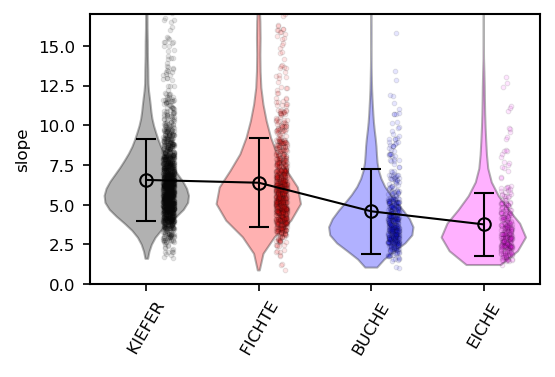

In [70]:
col = 'slope'
statistics = 'mean'
statistics_err = 'std'

save_name = col + '.svg'

scatter_size = 5
colors = ['k', 'r', 'b', 'magenta']
ylim = [0,17]

################### Plotting 
f = plt.figure(figsize= [5, 3])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.8)
ax = f.add_subplot(111)

# Violin plot
dists = [df.loc[df.family == family_id, col].values for family_id in families]
dists = [dist[np.isfinite(dist)] for dist in dists]

poly_coll = ax.violinplot(
    dists,
    families.keys(),
    points = 50,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.75,
)['bodies']

# Adjust violin plot sepcs
for i, coll in enumerate(poly_coll):
    coll.set_facecolor(colors[i])
    coll.set_edgecolor('k')
    coll.set_alpha(0.3)
    coll.set_linewidth(1)

# Scatter plot
for i, family_id in enumerate(families):
    y = df.loc[df.family == family_id, col].values
    x = np.ones_like(y) * family_id + 0.2
    x = np.random.uniform(0.15, 0.25, len(y)) + family_id
    ax.scatter(
        x,
        y,
        s=scatter_size,
        fc=colors[i],
        ec='k',
        alpha=0.1,
        lw=0.5,
        )

# Errorbar plot
ax.errorbar(
    df_grouped.loc[slice(None), (col, statistics)].index.values,
    df_grouped.loc[slice(None), (col, statistics)].values,
    df_grouped.loc[slice(None), (col, statistics_err)].values,
    marker='o',
    c='k',
    mec='k',
    mfc='none',
    ms=6,
    capsize=5,
)


ax.set_xticks(range(len(families)))
ax.set_xlim([-.5, len(families) -.5])
ax.set_xticklabels([family['family_name'].upper() for family in families.values()], rotation=60)

ax.set_ylabel(col)
ax.set_ylim(ylim)

plt.savefig(os.path.join(dir_plots, save_name), transparent=True)